# Predicting What Section a NYT Article is From Using a Naive Bayes Classifier

### By Derek Sawicki


## Introduction
In this notebook, I attempt a solution to this exercise, found on page 109 of the book Doing Data Science, by Rachel Schutt and Cathy O’Neil.
>First, you will use the <i>New York Times</i> Developer API to fetch recent articles from several sections of the Times. Then, using the simple Bernoulli model for word presence, you will implement a classifier which, given the text of an article from the New York Times, predicts the section to which the article belongs.
   
This being my first data science project of this scale, my goals were to become a little more familiar with the data science process and to get a sense for how and when to use a Naive Bayes algorithm.

## The approach used
I use the NYT API to gather data for 2000 articles. Ideally, the entire contents of each article would be used to train the model, but the API doesn't allow for that. I use what I believe is the next best thing - a snippet from the lead paragraph.

The frequencies of each word in the snippet are used to construct a feature matrix where each column represents a single word. Each article is represented by a vector whose entries are the number of times a certain word appears in that article's snippet.

## Setup

In [22]:
from urllib.request import urlopen
from urllib.error import URLError, HTTPError
import json

from nltk.corpus import stopwords
import re
import string
from collections import Counter
from time import sleep

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit



## Mining the data using the NYT API
As per the instructions in the exercise, I only grab articles that belong to the Arts, Business, Obituaries, Sports, or World sections. The API has a 5 second limit between requests, so this part can take quite a while. I store the url, headline, and lead_paragraph elements for each article in 1 of 5 .csv's, corresponding to the five sections. Stopwords are filtered out.

To follow along you'll need to [register for a <i>New York Times</i> Developer API Key](https://developer.nytimes.com/) and request access to
the Article Search API.

In [35]:
APIKEY = open('apikey.txt').read()

def getWords(snippet):
    if type(snippet) is not str:
        return []
    
    # Clean the words
    snippet = snippet.replace(u"\u2018", "").replace(u"\u2019", "").replace(u"\u201c","").replace(u"\u201d", "")
    snippet = re.sub('['+string.punctuation+']', '', snippet.lower())
    
    # Translate to list of words
    words = snippet.split()
    
    # remove stop words
    ret = [ x for x in words if x not in stopwords.words('english') ]
    return ','.join(ret)
 
    

# Stores the url, headline, and a snippet of 2000 recent NYT articles in csv files, separated
# by section_name.
section_map = {'Arts': 0,
                'Business': 1,
                'Obituaries': 2,
                'Sports': 3,
                'World': 4
                }
for section in section_map.keys():
    print ("loading section", section)
    urls = []
    headlines = []
    word_lists = []
    section_ = []

    # Get 20*10=200 articles from each section
    for page in range (40):
        
        # There is a 5 second limit on requests, I sleep for 7 seconds out of kindess
        sleep(7)
        
        
        # Request the most recent articles in this section
        req = ("http://api.nytimes.com/svc/search/v2/articlesearch.json?fq=section_name:(\'"
        +section+"\')&page="+str(page)+"&fl=web_url,abstract,lead_paragraph,lead_paragraph,headline,section_name&api-key="
        +APIKEY)
        
        # Catch exceptions. 
        try:
            result = urlopen(req)
        except HTTPError as e:
            print("exception: ", e.code)
            continue
        except URLError as e:
            print ("exception:", e.reason)
            continue
            
        # Parse result into dataframe ready lists
        jsonObj = json.loads(result.read())
        docs = jsonObj.get('response').get('docs')
        for article in docs:
            urls.append(article.get('web_url'))
            hl = article.get('headline').get('main')
            hl = hl.replace(u"\u2018", "").replace(u"\u2019", "").replace(u"\u201c","").replace(u"\u201d", "")
            headlines.append(hl)
            word_lists.append(getWords(article.get('lead_paragraph')))
            section_.append(section_map[section])

    # Store in dataframe
    raw_data = {
        'url': urls,
        'headline': headlines,
        'word_list': word_lists,
        'section': section_
        }
    df = pd.DataFrame(raw_data, columns = ['url', 'headline', 'word_list', 'section'])

    # Save dataframe to a file
    filename = section+'.csv'
    df.to_csv(filename, sep=',')

## Creating the feature matrix
#### What does Naive Bayes need?
The Naive Bayes Classifer is based on a statistical rule known as Bayes' theorem, which states:
   >P(A|B) = P(B|A)*P(A) / P(B)

For this problem, the goal is to predict the probability that an article belongs to a certain section(A) given the words in the article(B). To that end, I require: 
- P(A), the probability that an article belongs to a section, without knowing anything about what words it contains.
- P(B), the probability of seeings each word in an article, regardless of what section it belongs to.
- P(B|A), the probability that the words in the article would be what they are given that the article is from a certain section

The Naive Bayes classifier takes care of the computations, it just needs to be fed training examples.

I use the data gathered to construct a feature matrix where each column represents one word, and each entry holds the number of times that that word occurs in the article.

The word list is chosen by the most frequent k words from each section. I made k a parameter because I was curious about how it would effect accuracy. In the first attempt shown below I do not filter out words that are common between sections.

In [1]:
# Need to determine the dictionary to construct the feature vector from

# Discovers which k words are most frequent from each section, and compiles them into one
# list.
def DiscoverFeatures(k):
    dic = []
    for section in ['Arts', 'Business', 'Obituaries', 'Sports', 'World']:
        filename = section+'.csv'
        df = pd.read_csv(filename, encoding='latin-1')
        df = df.loc[:, ['word_list']]

        all_words = []
        for i, row in df.iterrows():
            if type(row['word_list']) is str:
                for word in row['word_list'].split(','):
                    all_words.append(word)

        dic.extend(  list(dict(Counter(all_words).most_common(k)).keys()) )

    return dic

# Count the frequencies of words from DiscoverFeatures() in each article, and construct the feature matrix
def ConstructFeatureMatrix(vocab):
    combinedData = pd.DataFrame()

    # Gather all the data into one dataframe
    for section in ['Arts', 'Business', 'Obituaries', 'Sports', 'World']:
        filename = section+'.csv'
        df = pd.read_csv(filename, encoding='latin-1')
        df = df.loc[:, ['word_list', 'section']]
        combinedData = pd.concat([combinedData, df])
        combinedData.reset_index()

    rows = []
    for i,row in combinedData.iterrows(): # For each example
        featureVector = [ 0 for i in range(len(vocab))]

        for word in range(len(vocab)): # For every word in the feature vector
            if type(row['word_list'])is str:
                if vocab[word] in row['word_list']:
                    featureVector[word] = row['word_list'].count(vocab[word])
            else:
                continue
        rows.append(featureVector)
    X = pd.DataFrame(rows)
    return X, combinedData['section']


For accuracy testing purposes, I wrote the following function to take in a dataset and return how well the bernoulli and multinomial classifiers score. The bernoulli method only cares whether or not a word appears in the article, while the multinomial method factors in how many times a word appears, if any. 

In [6]:

def RunNaiveBayes(X, y):
    #y = combinedData['section']

    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 0, train_size = 0.6)

    bernoulli = BernoulliNB(binarize=0.5)
    multinomial = MultinomialNB()

    bernoulli.fit(X_train, y_train)
    multinomial.fit(X_train, y_train)

    bern = bernoulli.score(X_test, y_test)
    mult = multinomial.score(X_test, y_test)
    
    return bern, mult




## Parameter Testing
Next I see what size k of the feature list produces the best score. It looks that the best score for both
estimators is achieved at around k=175. 

In [40]:
# Create a graph of size of vocab vs accuracy over all examples
bernScore = []
multScore = []
K = range(30,300,30)
for k in K:
    features = DiscoverFeatures(k)
    X, y = ConstructFeatureMatrix(vocab=features)
    
    b,m = RunNaiveBayes(X, y)
    bernScore.append(b)
    multScore.append(m)


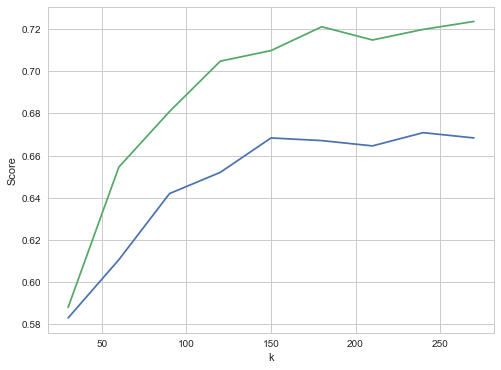

In [41]:
plt.figure(figsize=(8,6))
plt.ylabel("Score")
plt.xlabel("k")
plt.plot(K, bernScore, label="bernoulliNB")
plt.plot(K, multScore, label="multinomialNB")

## Plotting learning curves
To gain a better understanding of how my classifier is performing, I plot accuracy vs training set size. 

In [47]:
import warnings
warnings.simplefilter("ignore")

def plotLearningCurve(estimator, X, y, title):
    plt.figure(figsize=(8,6))
    plt.title(title+" Learning Curve")
    plt.xlabel("N Training Examples")
    plt.ylabel("Score")
    plt.grid()
    train_sizes_abs, train_scores, test_scores = learning_curve(estimator, X, y)
    plt.plot(train_sizes_abs, train_scores, label="Training score")
    plt.plot(train_sizes_abs, test_scores, label="Test score")
    
    
features = DiscoverFeatures(170)
X, y = ConstructFeatureVector(vocab=features)

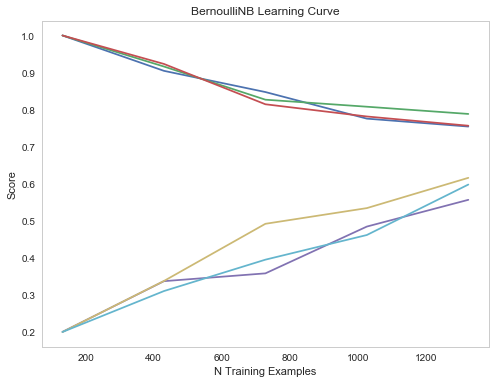

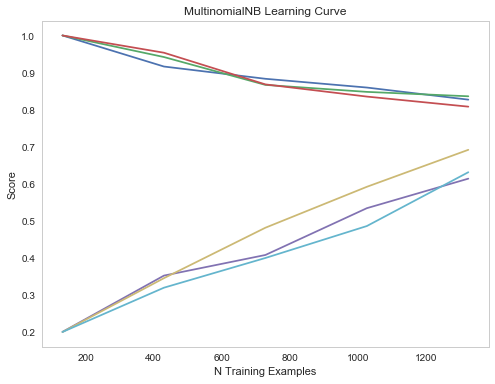

In [48]:
plotLearningCurve(BernoulliNB(binarize=0.5), X, y, "BernoulliNB")
plotLearningCurve(MultinomialNB(), X, y, "MultinomialNB")


## Analysis
In each plot, there are two 'bundles' of curves plotted - the top bundle represents the training scores and the bottom bundle represents the cross validation score. There are bundles instead of singular lines because the function that plots the curves uses three random subsets of the data.

These learning curves look to reveal a case of high bias, which means that even with more data, the score will cap out at around 0.7 for bernoulliNB and multinomialNB. To correct the under-fitting, I try changing the way the dictionary for the feature vector is chosen. Initially, frequent words are just picked from each section and joined together. It might be a better idea to filter out words that are common between sections.

## An attempt to increase accuracy
I have the suspicion that filtering out words that are common between sections would raise the accuracy of the model, so I try that by modifying the function that chooses the words for the feature matrix.

In [8]:
def DiscoverFeatures_v2(k):
    vocab = []
    for section in ['Arts', 'Business', 'Obituaries', 'Sports', 'World']:
        filename = section+'.csv'
        df = pd.read_csv(filename, encoding='latin-1')
        df = df.loc[:, ['word_list']]

        section_vocab = []
        for i, row in df.iterrows():
            if type(row['word_list']) is str:
                for word in row['word_list'].split(','):
                    section_vocab.append(word)

        to_add = list(dict(Counter(section_vocab).most_common(k)).keys())
        
        # This line filters out common words between sections
        to_add = [ word for word in to_add if word not in vocab ]
        
        vocab.extend( to_add )

    return vocab

And now I replot the learning curves to see if there is any improvement...

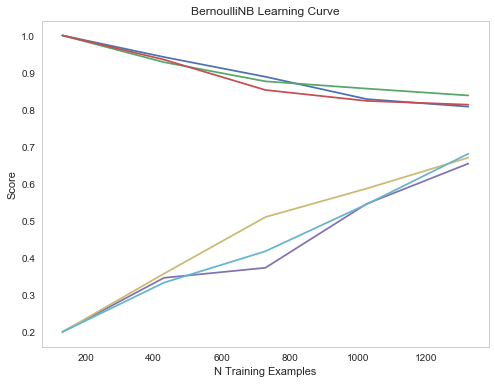

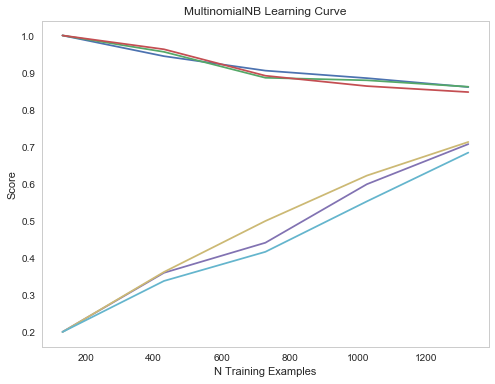

In [49]:
features = DiscoverFeatures_v2(170)
X, y = ConstructFeatureVector(vocab=features)
plotLearningCurve(BernoulliNB(binarize=0.5), X, y, "BernoulliNB")
plotLearningCurve(MultinomialNB(), X, y, "MultinomialNB")

I think the accuracy did improve, but it's hard to tell so here's a clearer grapical comparison.

In [38]:
# Calculate bernoulli/multinomial scores with the old feature picker
features = DiscoverFeatures(170)
X, y = ConstructFeatureVector(vocab=features)
b1, m1 = RunNaiveBayes(X, y)

# Calculate scores with the new
features = DiscoverFeatures_v2(170)
X, y = ConstructFeatureVector(vocab=features)
b2, m2 = RunNaiveBayes(X, y)


[]

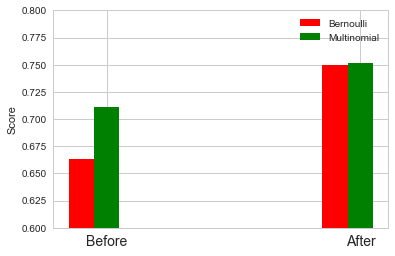

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)

bern = [b1, b2]
mult = [m1, m2]

ind = np.arange(2)
width = 0.1

before = ax.bar(ind, bern, width, color='red')
after = ax.bar(ind+width, mult, width, color='green')

ax.set_ylim(.6, .8)
ax.set_ylabel('Score')
ax.set_xticks(ind+width)
tickNames = ax.set_xticklabels(['Before', 'After'])
plt.setp(tickNames, fontsize=14)
ax.legend((before[0], after[0]), ('Bernoulli', 'Multinomial'))

plt.plot()

## Conclusion
With this method I was able to reach an accuracy of around 0.75 using both the Bernoulli and Multinomial Naive Bayes classifiers. It appears that with more data it could get up to 0.80

If I were to continue with this project, I would probably gather more data, then explore how more complex variations of the Naive Bayes classifier compare. 
